In this notebook, I'll inspect a dataset with Hidden Stratification that is synthetically generated. 

I will present an investigation of the misclassified samples using Scatter plots and the MAGIC tool.

# Dataset Creation

The data we'll use consists of 2 groups, each has 350 samples: group **A** and group **B**.

One-third of group A is actrually a differnt group that has different chracteristics. We'll call it  **Hidden A** group. 

The data consists of 3 attributes: **att1**, **att2** and **att3**.

While att1 and att2 are attributes that separate the groups, att3 is a dummy attribute whose sole purpose is to add noise to the data.

<br>

The attributes distribute as follows:

* **Group A** : $att1\sim N(\mu=0.75, \sigma ^2 = 2.25 ^2)$ , $att2\sim N(\mu=2, \sigma ^2 = 2.5^2)$ .
* **Hidden A group** : $att1\sim N(\mu=6.5, \sigma ^2 = 1.75^2)$ , $att2\sim N(\mu=8, \sigma ^2 = 1.75^2)$ .
* **Group B** : $att1\sim N(\mu=10, \sigma ^2 = 2^2)$ , $att2\sim N(\mu=2, \sigma ^2 = 2^2)$ .

In addition, the noise across all groups distributes as follows: $N(\mu=5, \sigma ^2 = 2.5^2)$ .

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

np.random.seed(seed=0)

In [2]:
group_size = 350

hidden_group_size = int(group_size / 3)
group_A_size = group_size - hidden_group_size
group_B_size = group_size

group_a_att1 = np.random.normal(loc=0.75, scale=2.25, size=(group_A_size, 1))
group_a_att2 = np.random.normal(loc=2, scale=2.5, size=(group_A_size, 1))

group_hidden_a_att1 = np.random.normal(loc=6.5, scale=1.75, size=(hidden_group_size, 1))
group_hidden_a_att2 = np.random.normal(loc=8, scale=1.75, size=(hidden_group_size, 1))

group_b_att1 = np.random.normal(loc=10, scale=2, size=(group_B_size, 1))
group_b_att2 = np.random.normal(loc=2, scale=2, size=(group_B_size, 1))

noise_values = np.random.normal(loc = 5, scale = 2.5, size = (2 * group_size, 1))

class_values = np.array(['A'] * group_A_size + ['Hidden_A'] * hidden_group_size + ['B'] * group_B_size).reshape(-1,1)

att1_values = np.concatenate((group_a_att1, group_hidden_a_att1, group_b_att1))
att2_values = np.concatenate((group_a_att2, group_hidden_a_att2, group_b_att2))

data = np.concatenate((att1_values, att2_values, noise_values, class_values), axis = 1)

df = pd.DataFrame(data, columns = ['att1', 'att2', 'att3', 'class'])

df = df.astype({'att1': 'float64', 'att2': 'float64', 'att3': 'float64'})

We can use Scatter Plot and Pairplot to plot the groups as follows:

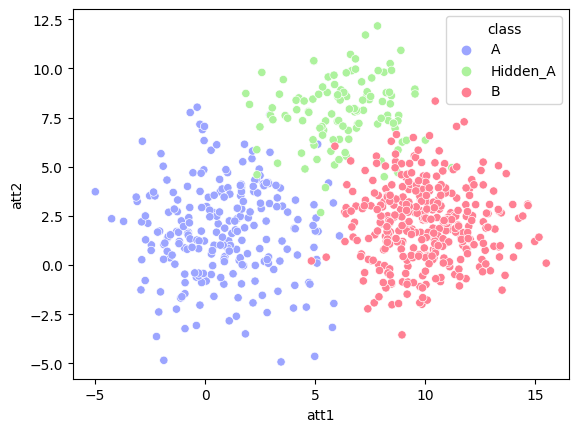

In [3]:
sns.scatterplot(data=df, x="att1", y="att2", hue="class", palette = {'A': '#9ca5ff', 'B': '#ff8093', 'Hidden_A': '#adf29d'});

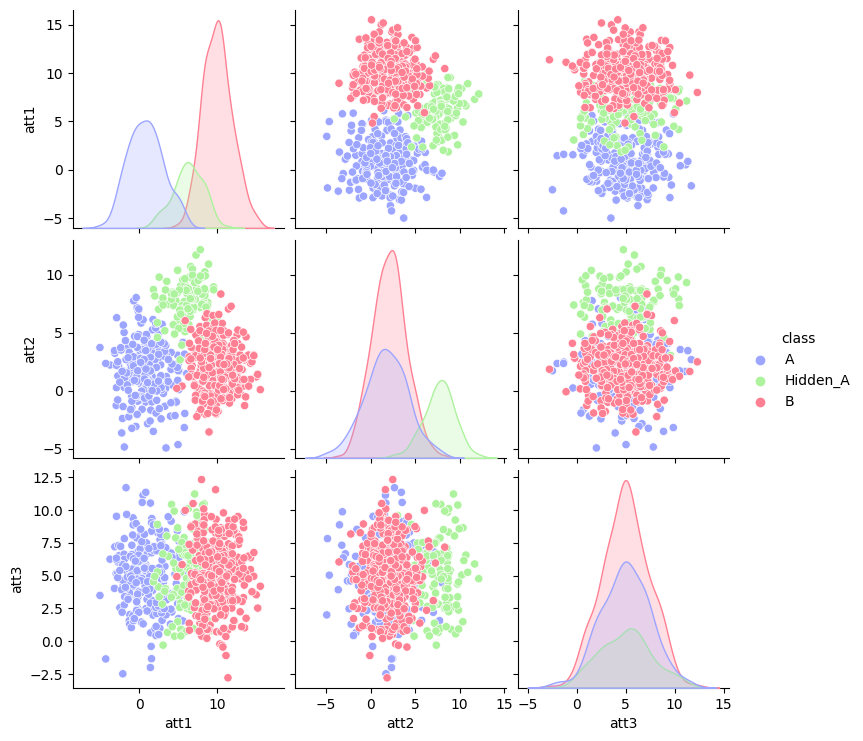

In [4]:
sns.pairplot(df, hue="class", palette = {'A': '#9ca5ff', 'B': '#ff8093', 'Hidden_A': '#adf29d'});

To support the Stratification phenomenon, we will "hide" the *Hidden A* group by labeling it as A.

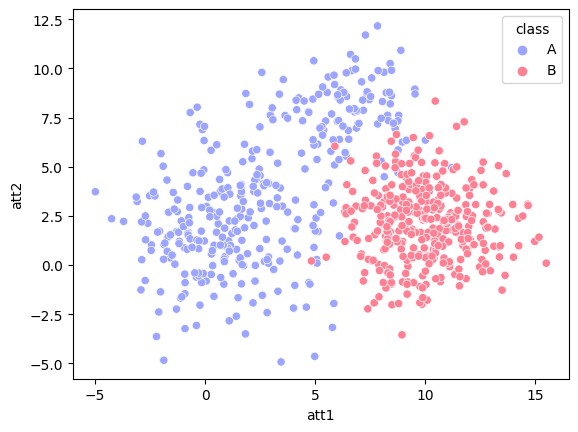

In [5]:
df1 = df.copy(deep = True)

df1['class'] = df1['class'].replace('Hidden_A', 'A')

sns.scatterplot(data=df1, x="att1", y="att2", hue="class", palette = {'A': '#9ca5ff', 'B': '#ff8093'});

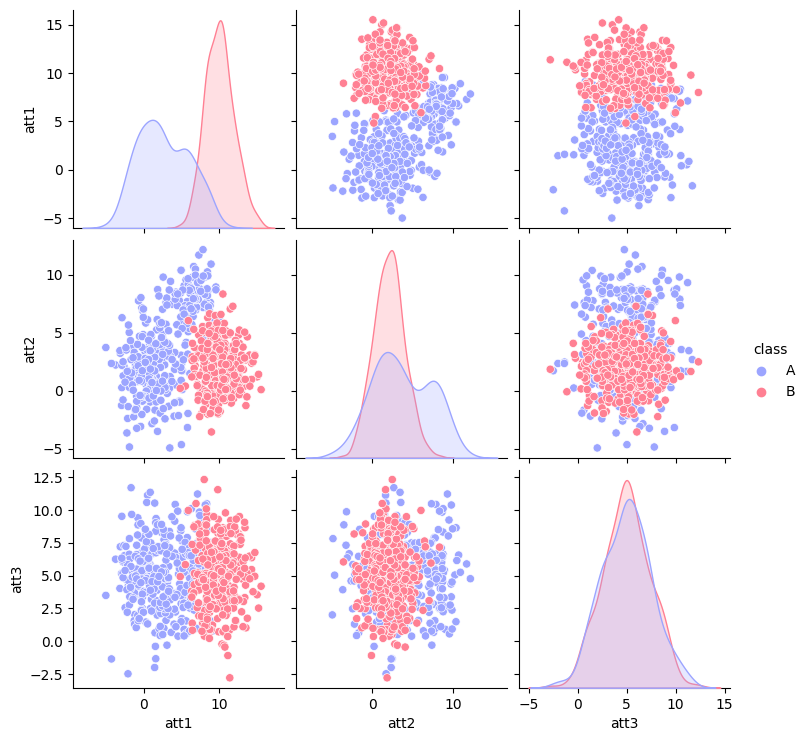

In [6]:
sns.pairplot(df1, hue="class", palette = {'A': '#9ca5ff', 'B': '#ff8093'});

# Classification Using SVM And KNN

Now, let's examine the KNN and the SVM classifiers performance when classifying the data.

In [7]:
X = df1.drop(['class'],axis=1)
y = df1['class']

In [8]:
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.20,random_state=41)
print("train size:", X_train.shape, y_train.shape)
print("test size:" , X_test.shape, y_test.shape)

train size: (560, 3) (560,)
test size: (140, 3) (140,)


## The SVM Classifier

In [9]:
parameters = {
              'C':[0.1, 1, 10],               
              'gamma':['scale', 'auto'],
              'kernel':('linear', 'poly','rbf', 'sigmoid')              
             }
svm11 = GridSearchCV(SVC(), parameters, cv=5)
svm11.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10], 'gamma': ['scale', 'auto'],
                         'kernel': ('linear', 'poly', 'rbf', 'sigmoid')})

In [10]:
svm = SVC(kernel = svm11.best_params_['kernel'],
           C = svm11.best_params_['C'],
           gamma = svm11.best_params_['gamma'])
svm.fit(X_train, y_train)         
svm.score(X_test, y_test) 

0.9642857142857143

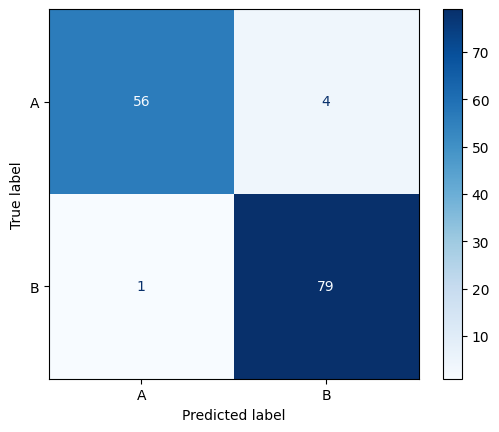

In [11]:
ConfusionMatrixDisplay.from_estimator(svm, X_test, y_test,values_format="d",cmap='Blues');

In [12]:
pred1=svm.predict(X_test)
print(classification_report(y_test,pred1,digits=4))

              precision    recall  f1-score   support

           A     0.9825    0.9333    0.9573        60
           B     0.9518    0.9875    0.9693        80

    accuracy                         0.9643       140
   macro avg     0.9671    0.9604    0.9633       140
weighted avg     0.9649    0.9643    0.9642       140



## The KNN Classifier

In [13]:
parameters = {
              'algorithm': ['ball_tree', 'kd_tree', 'brute'],
              'n_neighbors': [3,5,7,9],    
              'weights' : ['uniform', 'distance']              
             }
knn11 = GridSearchCV(KNeighborsClassifier(), parameters, cv=5)
knn11.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': [3, 5, 7, 9],
                         'weights': ['uniform', 'distance']})

In [14]:
knn = KNeighborsClassifier(algorithm = knn11.best_params_['algorithm'],
                           n_neighbors =  knn11.best_params_['n_neighbors'],
                           weights = knn11.best_params_['weights'])

In [15]:
knn.fit(X_train, y_train)         
knn.score(X_test, y_test) 

0.95

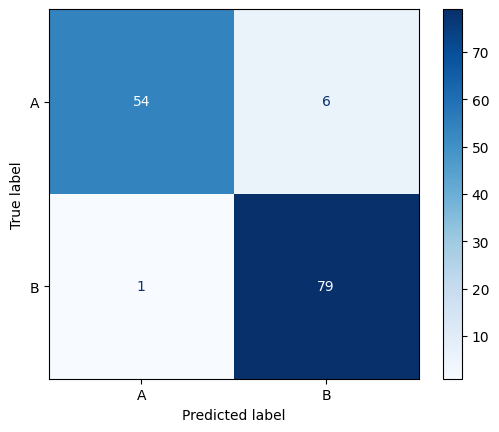

In [16]:
ConfusionMatrixDisplay.from_estimator(knn, X_test, y_test, values_format="d", cmap='Blues')

# Misclassification Analysis (A misclassified as B)

For this research purposes I'll use the cases in which A was misclassified as B.

## 2.a Misclassification Analysis With Scatter Plot

First - let's compare the svm and the KNN misclassifications with the original data set where the stratified subclass is not hidden.

For the KNN we get:

the index of the problematic sample misclassified by the knn:
13    298
59    218
64    260
73    275
81    335
99      3
Name: index, dtype: int64


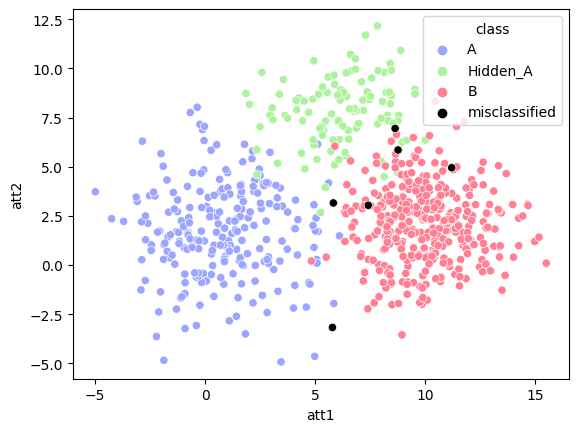

In [17]:
predicions = knn.predict(X_test)
misclassification_index = [i for i in range(len(X_test)) if predicions[i] == 'B' and y_test.iloc[i] == 'A']
index_in_df = y_test.reset_index().iloc[misclassification_index]['index']
print(f'the index of the problematic sample misclassified by the knn:\n{index_in_df}')

df2 = df.copy(deep=True)
df2.loc[index_in_df, 'class'] = 'misclassified'

sns.scatterplot(data=df2.drop(index_in_df), x="att1", y="att2", hue="class", palette = {'A': '#9ca5ff', 'B': '#ff8093', 'Hidden_A': '#adf29d'});
sns.scatterplot(data=df2.loc[index_in_df], x="att1", y="att2", hue="class", palette = {'misclassified': 'black'});

Note: if we hide the hidden group, the plot will be as follow:

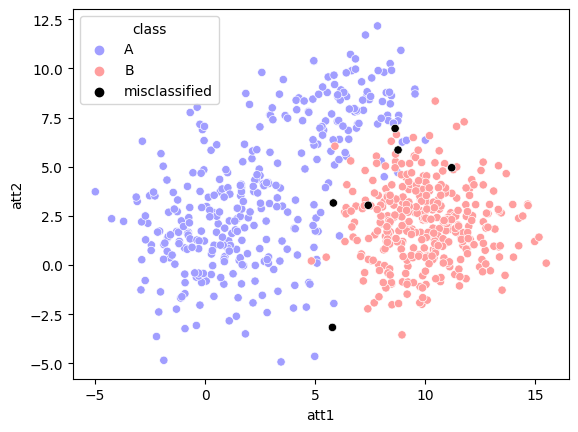

In [18]:
df2 = df1.copy(deep=True)
df2.loc[index_in_df, 'class'] = 'misclassified'

sns.scatterplot(data=df2.drop(index_in_df), x="att1", y="att2", hue="class", palette = {'A': '#a19eff', 'B': '#ff9e9e', 'Hidden_A': '#9effb5'});
sns.scatterplot(data=df2.loc[index_in_df], x="att1", y="att2", hue="class", palette = {'misclassified': 'black'});

Now, let's look at the SVM:

the index of the problematic sample misclassified by the svm:
26    252
64    260
73    275
81    335
Name: index, dtype: int64


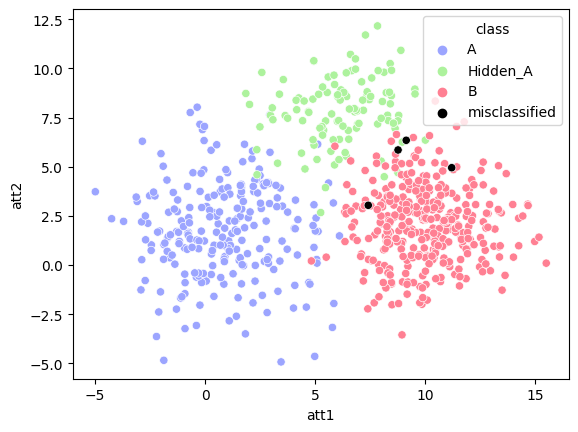

In [19]:
predicions = svm.predict(X_test)
misclassification_index = [i for i in range(len(X_test)) if predicions[i] == 'B' and y_test.iloc[i] == 'A']
index_in_df = y_test.reset_index().iloc[misclassification_index]['index']
print(f'the index of the problematic sample misclassified by the svm:\n{index_in_df}')

df2 = df.copy(deep=True)
df2.loc[index_in_df, 'class'] = 'misclassified'

sns.scatterplot(data=df2.drop(index_in_df), x="att1", y="att2", hue="class", palette = {'A': '#9ca5ff', 'B': '#ff8093', 'Hidden_A': '#adf29d'});
sns.scatterplot(data=df2.loc[index_in_df], x="att1", y="att2", hue="class", palette = {'misclassified': 'black'});

We can see that the classifiers have 3 samples in common: 260, 275 and 335.


## 2.b Misclassification Anlysis With The MAGIC Tool

Using the MAGIC tool, one can see that the test-data flows in 3 channels: 

In the middle, colored with red, is the B group. 
To its left we can see one group labaled as A (colored with blue) and to its right - another group labeled as A (colored with blue as well).

This easilly illustrates the fact that the group A consists of two subgroups.

We also can see that the left part of the tree captures the "original" group A while the right side captures the hidden group A.

In [20]:
expected_label = 'A'
predicted_label = 'B'

In [21]:
#@title Press the run button to load the MAGIC tool

import numpy as np
import graphviz
import matplotlib.colors as mc
import re
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from PIL import Image

PRESENT_ALL = 'all'
PRESENT_VISITED = 'visited'
PRESENT_MISCLASSIFIED = 'misclassified'

##################
## Graphvitz utils

replace_words = ['<thead>', '<tbody>', '</thead>', '</tbody>', '\n', '\rn', '<table border="1" class="dataframe">',
                 '</table>']
pattern = '|'.join(replace_words)

def dataframe_to_graphviz_table(df):
    '''
    Translates a html table to graphviz format
    references:
    https://renenyffenegger.ch/notes/tools/Graphviz/attributes/label/HTML-like/index
    https://graphviz.org/Gallery/gradient/table.html
    '''
    html_table = df.to_html()
    return re.sub(pattern, '', html_table).replace('th', 'td').replace('<td>', '<td border="1" bgcolor = "white">')

def to_graphviz_format(node_header, cm):
    cm_table = dataframe_to_graphviz_table(cm)
    return '<<table border = "0">' \
           '<tr><td border = "0" colspan="3"><b>%s</b></td></tr>' \
            '%s' \
           '</table>>' % (node_header, cm_table)

####################
def create_legend (expected_label, predicted_label, expected_label_color, predicted_label_color):
    elc = color_to_hex(expected_label_color)
    plc = color_to_hex(predicted_label_color)
    return f'<<table border = "0">' \
           f'<tr><td border = "1" bgcolor= "{elc}"> expected label </td> \
                <td border = "1" bgcolor= "{plc}"> predicted label </td></tr>' \
           f'<tr><td border = "1" bgcolor= "{elc}"> {expected_label} </td> \
                <td border = "1" bgcolor= "{plc}"> {predicted_label} </td></tr>' \
           f'</table>>'

def create_cm_for_node(tp, fp, tn, fn, true_label, false_label):
    if tp == 0 and fp == 0 and tn == 0 and fn == 0:
        return None
    else:
        return pd.DataFrame({false_label: [tn, fn], true_label: [fp, tp]}, index = [false_label,true_label])

def get_nodes_visits_count_list(n_nodes, node_indicator, samples_ids):
    visits_count = [0] * n_nodes
    for sample_id in samples_ids:
        # obtain ids of the nodes `sample_id` goes through, i.e., row `sample_id`
        node_indexes = node_indicator.indices[
                     node_indicator.indptr[sample_id]: node_indicator.indptr[sample_id + 1]
                     ]
        for node_index in node_indexes:
            visits_count[node_index] += 1
    return visits_count

def color_to_hex(color):
    try:
        color = mc.cnames[color]
    except:
        pass
    return color

def merge_color(first_color, first_color_quantity, second_color, second_color_quantity):
    if first_color_quantity == 0 and second_color_quantity == 0:
        return 'white'
    else:
        fc = color_to_hex(first_color)
        sc = color_to_hex(second_color)
        fc_rgb = tuple(int(fc.lstrip('#')[i:i+2], 16) for i in (0, 2, 4))
        sc_rgb = tuple(int(sc.lstrip('#')[i:i+2], 16) for i in (0, 2, 4))
        total = first_color_quantity + second_color_quantity
        adjusted_r = round((first_color_quantity * fc_rgb[0] + second_color_quantity * sc_rgb[0]) / total)
        adjusted_g = round((first_color_quantity * fc_rgb[1] + second_color_quantity * sc_rgb[1]) / total)
        adjusted_b = round((first_color_quantity * fc_rgb[2] + second_color_quantity * sc_rgb[2]) / total)
        return '#%02x%02x%02x' % (adjusted_r, adjusted_g, adjusted_b)

def plot_misclassification_in_tree(clf, X, y, expected_label, predicted_label, expected_label_color, predicted_label_color,
                                   show_cm = True, present = PRESENT_ALL):
    y = np.array(y)  # Will be easier if y is guaranteed to be of type np array
    v = graphviz.Digraph()

    v.node(str(-1), create_legend(expected_label, predicted_label, expected_label_color, predicted_label_color),
           {'shape': 'component', 'style': 'filled', 'fillcolor': 'white'})

    n_nodes = clf.tree_.node_count
    children_left = clf.tree_.children_left
    children_right = clf.tree_.children_right
    feature = clf.tree_.feature
    threshold = clf.tree_.threshold

    classification = clf.predict(X)
    node_indicator = clf.decision_path(X)

    # Step 1: check how the true data traverse along the classifier
    expected_label_labeled_samples_ids = [i for i in range(len(X)) if y[i] == expected_label]
    predicted_label_labeled_samples_ids = [i for i in range(len(X)) if y[i] == predicted_label]

    expected_label_labeled_visit_count = get_nodes_visits_count_list(n_nodes, node_indicator, expected_label_labeled_samples_ids)
    predicted_label_labeled_visits_count = get_nodes_visits_count_list(n_nodes, node_indicator, predicted_label_labeled_samples_ids)

    # Step 2: inspect how the classifier would classify the samples - and create a confusion marix for it.
    true_positive_samples_ids = [i for i in range(len(X)) if
                                 y[i] == expected_label and classification[i] == expected_label]
    false_positive_samples_ids = [i for i in range(len(X)) if
                                  y[i] == predicted_label and classification[i] == expected_label]
    true_negative_samples_ids = [i for i in range(len(X)) if
                                 y[i] == predicted_label and classification[i] == predicted_label]
    false_negative_samples_ids = [i for i in range(len(X)) if
                                  y[i] == expected_label and classification[i] == predicted_label]

    tp_visits_count = get_nodes_visits_count_list(n_nodes, node_indicator, true_positive_samples_ids)
    fp_visits_count = get_nodes_visits_count_list(n_nodes, node_indicator, false_positive_samples_ids)
    tn_visits_count = get_nodes_visits_count_list(n_nodes, node_indicator, true_negative_samples_ids)
    fn_visits_count = get_nodes_visits_count_list(n_nodes, node_indicator, false_negative_samples_ids)

    if PRESENT_ALL == present:
        nodes_ids_to_plot = range(n_nodes)
    elif PRESENT_VISITED == present:
        total_visits_count = [sum(x) for x in zip(tp_visits_count, fp_visits_count, tn_visits_count, fn_visits_count)]
        nodes_ids_to_plot = [i for i in range(len(total_visits_count)) if total_visits_count[i] > 0]
    elif PRESENT_MISCLASSIFIED == present:
        nodes_ids_to_plot = [i for i in range(len(fn_visits_count)) if fn_visits_count[i] > 0]
    else:
        raise Exception('Uknown present value: %s' % present)

    for i in nodes_ids_to_plot:
        node_id = str(i)

        if children_left[i] == children_right[i]: # this is a leaf
            label = str(clf.classes_[np.argmax(clf.tree_.value[i])])
            if show_cm:
                cm = create_cm_for_node(tp_visits_count[i], fp_visits_count[i], tn_visits_count[i], fn_visits_count[i], expected_label, predicted_label)
                if cm is None:
                    node_content = label
                else:
                    node_content = to_graphviz_format(label, cm)
            else:
                node_content = label
            peripheries = '2' if fn_visits_count[i] > 0 else '1'
            fill_color = merge_color(expected_label_color, expected_label_labeled_visit_count[i], predicted_label_color, predicted_label_labeled_visits_count[i])
            v.node(node_id, node_content, {'shape': 'rect', 'style': 'filled', 'fillcolor': fill_color, 'peripheries': peripheries})

        else: # this is a split node
            node_feature = X.columns[feature[i]]
            node_tresshold = threshold[i]

            label = str(node_feature)
            if show_cm:
                cm = create_cm_for_node(tp_visits_count[i], fp_visits_count[i], tn_visits_count[i], fn_visits_count[i], expected_label, predicted_label)
                if cm is None:
                    node_content = label
                else:
                    node_content = to_graphviz_format(label, cm)
            else:
                node_content = label

            fill_color = merge_color(expected_label_color, expected_label_labeled_visit_count[i], predicted_label_color, predicted_label_labeled_visits_count[i])
            peripheries = '2' if fn_visits_count[i] > 0 else '1'
            v.node(node_id, node_content, {'shape': 'rect', 'style': 'filled', 'fillcolor': fill_color, 'peripheries': peripheries})

            if children_left[i] in nodes_ids_to_plot:
                v.edge(node_id, str(children_left[i]), node_feature + "<=" + str(round(node_tresshold, 5)))
            if children_right[i] in nodes_ids_to_plot:
                v.edge(node_id, str(children_right[i]), node_feature + ">" + str(round(node_tresshold, 5)))

    v.node(str(n_nodes), f'Total misclassification: {len(false_negative_samples_ids)}/{len(X)}',  {'shape': 'underline'}) # TODO replace with existing conut
    # v.render(directory='doctest-output', view=True, format='jpeg')
    output_path = v.render(format = 'jpg')
    im = Image.open(output_path) 
      
    # resize the image for better presentation 
    width, height = int(im.width / im.height * 1000), 1000
    im_resized = im.resize((width, height))
    return clf, im_resized

def plot_misclassification(X_train, y_train, X_test, y_test, expected_label, predicted_label, expected_label_color, predicted_label_color,
                           show_cm = True, present = PRESENT_ALL, max_depth = None):
    # Note: setting random_state to a constant number for deterministic tree creation. See: https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
    clf = DecisionTreeClassifier(random_state=42) if max_depth is None else  DecisionTreeClassifier(max_depth=max_depth, random_state=42)
    clf.fit(X_train, y_train)
    return plot_misclassification_in_tree(clf, X_test, y_test, expected_label, predicted_label, expected_label_color, predicted_label_color, show_cm, present)


def extract_decision_predicate_by_path(clf, X):
    X_test = X.to_numpy()

    feature = clf.tree_.feature
    threshold = clf.tree_.threshold

    node_indicator = clf.decision_path(X_test)
    leaf_id = clf.apply(X_test)
    samples_rules_dict = {}

    for sample_id in range(len(X)):
        rules = []
        # obtain ids of the nodes `sample_id` goes through, i.e., row `sample_id`
        node_index = node_indicator.indices[
                     node_indicator.indptr[sample_id]: node_indicator.indptr[sample_id + 1]
                     ]

        for node_id in node_index:
            # continue to the next node if it is a leaf node
            if leaf_id[sample_id] == node_id:
                continue

            # check if value of the split feature for sample 0 is below threshold
            if X_test[sample_id, feature[node_id]] <= threshold[node_id]:
                threshold_sign = "<="
            else:
                threshold_sign = ">"

            rules.append(f'(x[\'{X.columns[feature[node_id]]}\'] {threshold_sign} {threshold[node_id]})')

        samples_rules_dict[X.index[sample_id]] = " & ".join(rules)
    return samples_rules_dict


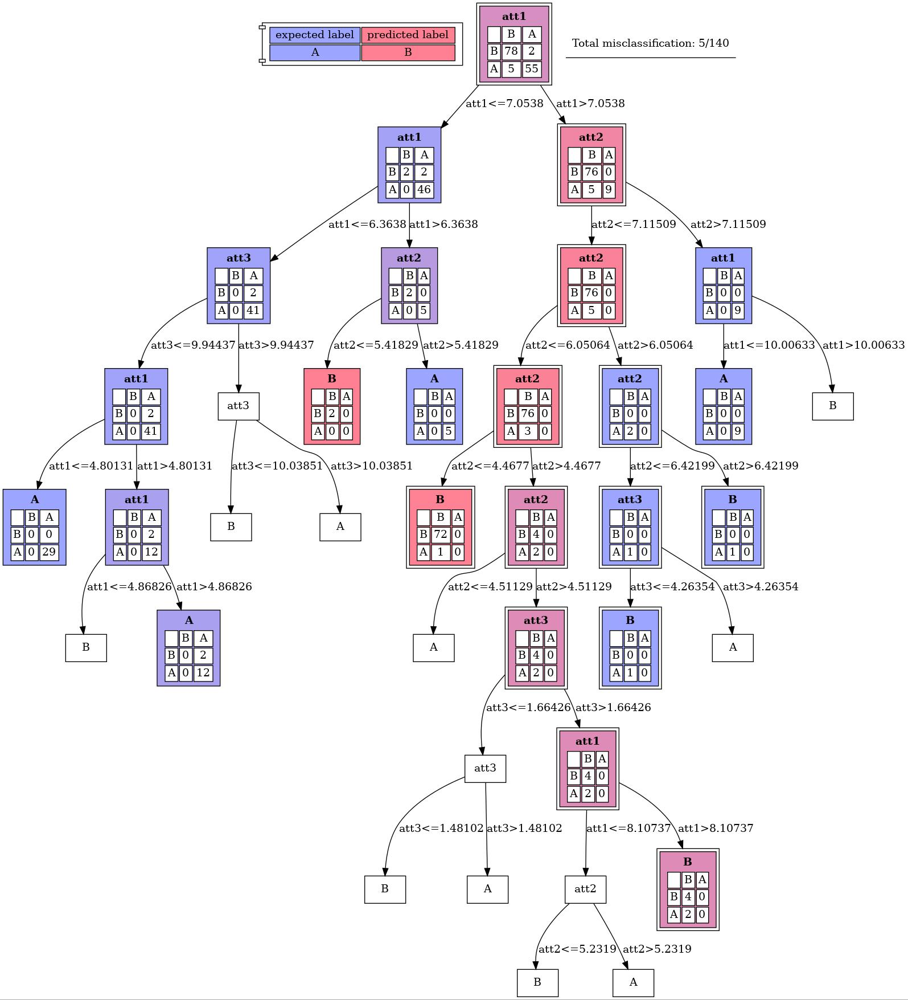

In [22]:
clf, plot = plot_misclassification(X_train, y_train, X_test, y_test, expected_label, predicted_label, '#9ca5ff', '#ff8093',
                           show_cm = True, present = 'all')
plot

# Conclusion

In this notebook the MAGIC tool had a great adventage over the tradional Scatter plot in uncovering hidden subclasses of a given class. 

Whether the existence of this subclass impairs the classification or not, its identification is important to the work of the data scientist.

<hr>

#Appendix: Illustrations For The Questionnaire

In the questionnaire, for the MAGIC tool I used a tree with max depth of 6 as it easier for the reader to comprehend a "shorter" tree. Note that limiting the depth didn't add more misclassified samples and therefore kept the same conclusions that were mentioned in this notebook.

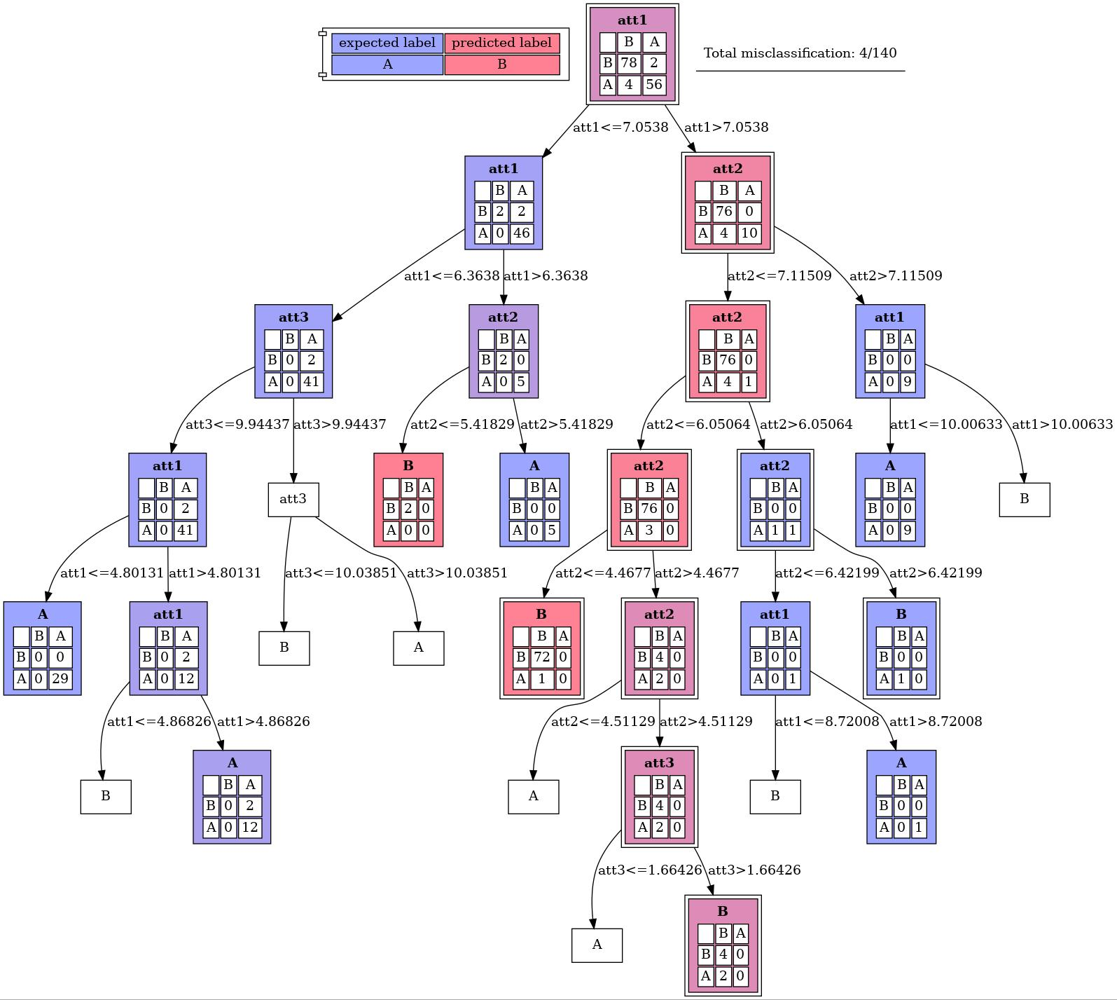

In [23]:
clf, plot = plot_misclassification(X_train, y_train, X_test, y_test, expected_label, predicted_label, '#9ca5ff', '#ff8093',
                           show_cm = True, present = 'all', max_depth = 6)
plot

As for the Scatter plots, I used the misprediction by the KNN as presented above, but with hidden-A group hidden and colored the same way as the rest of A group:

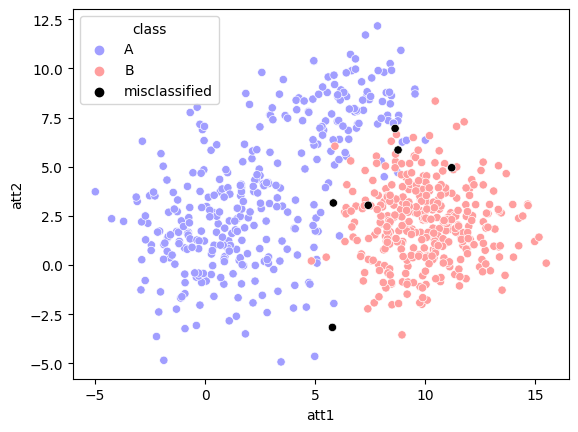

In [24]:
predicions = knn.predict(X_test)
misclassification_index = [i for i in range(len(X_test)) if predicions[i] == 'B' and y_test.iloc[i] == 'A']
index_in_df = y_test.reset_index().iloc[misclassification_index]['index']

df2 = df1.copy(deep=True)
df2.loc[index_in_df, 'class'] = 'misclassified'

sns.scatterplot(data=df2.drop(index_in_df), x="att1", y="att2", hue="class", palette = {'A': '#a19eff', 'B': '#ff9e9e', 'Hidden_A': '#9effb5'});
sns.scatterplot(data=df2.loc[index_in_df], x="att1", y="att2", hue="class", palette = {'misclassified': 'black'});